# Калибровка результатов классификации

Калибровка нужна для

- правильного понимания, насколько результатам алгоритма можно доверять
- для более точного решения задач и передаче верной "уверенности модели" далее
- для настройки функции ошибки

В основе калибровки лежит сравнение `уверенности (confidence)` и `точности (accuracy)` на тестовой выборке.

**Необходим для корректировки миноритарных классов!**

Основные методы: 

- Непараметрический метод гистограммной калибровки (Histogram Binning) (слабый метод, проблемы с бинами скоринга)
- Непараметрический метод – изотонная регрессия (Isotonic Regression) (наиболее используемый из непарам.методов)
- Параметрическая калибровка Платта (Platt calibration) (лучше всего для SVM, но и для всех из sklearn)
- Логистическая регрессия в пространстве логитов (современный и постоянно развивающийся методо)
- Параметрические методы: scaling-binning calibrator (сочитает несколько методов, на практике не использовал)
- Деревья калибровки (на практике не использовал)
- Maximum Mean Calibration Error (MMCE)
- и многие другие

Описание методов: https://dyakonov.org/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/

EL5:

- Берем вероятность относительно входного распределения, возвращаем реальную вероятность события
- Идеальная калибровка - это калибровка от 0.0 до 1.1 (как 0.5 отметка на roc-auc)

Посмотреть на Sklearn:
https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

In [58]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


In [59]:
# генерим набор данных и сделаем базовую модель
X, y = datasets.make_classification(n_samples=100000, n_features=15, n_informative=2, n_redundant=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# RF без параметров
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)
y_pred_rfc = model_rfc.predict(X_test)
print("Precision: %0.2f" % precision_score(y_test, y_pred_rfc))
print("Recall: %0.2f" % recall_score(y_test, y_pred_rfc))
print("F1: %0.2f\n" % f1_score(y_test, y_pred_rfc))

# LR без параметров
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print("Precision: %0.2f" % precision_score(y_test, y_pred_lr))
print("Recall: %0.2f" % recall_score(y_test, y_pred_lr))
print("F1: %0.2f" % f1_score(y_test, y_pred_lr))

Precision: 0.98
Recall: 0.95
F1: 0.97

Precision: 0.89
Recall: 0.93
F1: 0.91


**Запоними:**

- скоринг выше линии Идеала - модель очень уверена в решении
- скоринг ниже линии Идеала - модель очень не уверена в решении

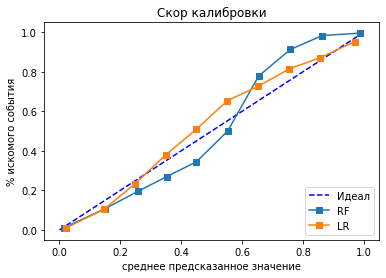

In [60]:
# Нарисуем график позиционирования нашего результата

fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Идеал")
ax.set_ylabel("% искомого события")
ax.set_xlabel("среднее предсказанное значение")
ax.set_title('Скор калибровки')

prob_pos_rfc = model_rfc.predict_proba(X_test)[:, 1]
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label="%s" % ('RF'))

prob_pos_lr = model_lr.predict_proba(X_test)[:, 1]
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_test, prob_pos_lr, n_bins=10)
ax.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-", label="%s" % ('LR'))

ax.legend(loc="lower right")
plt.show()

### Проверим, нужна ли калибровка (Brier score)

Применяется только к алгоритмам, у которых есть возможность выдавать вероятности(predict_proba)

Применяем BRIER SCORE:

- имеет параметры от 1 до 0, чем ближе к 0, тем лучше
- показывает разницу, между вероятностью из predict_proba и настоящей вероятностью (идеальной)

Brier score RFC: 0.03
Brier score LR: 0.09


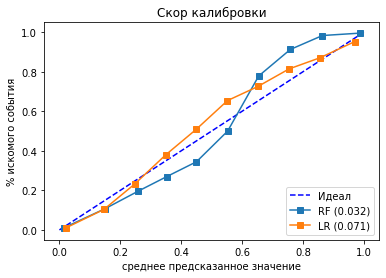

In [61]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Идеал")
ax.set_ylabel("% искомого события")
ax.set_xlabel("среднее предсказанное значение")
ax.set_title('Скор калибровки')

model_rfc_score = brier_score_loss(y_test, y_pred_rfc, pos_label=y.max())
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos_rfc, n_bins=10)

ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%0.3f)" % ('RF', model_rfc_score))
print("Brier score RFC: %0.2f" % brier_score_loss(y_test, y_pred_rfc))


model_lr_score = brier_score_loss(y_test, prob_pos_lr, pos_label=y.max())
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos_lr, n_bins=10)

ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%0.3f)" % ('LR', model_lr_score))
print("Brier score LR: %0.2f" % brier_score_loss(y_test, y_pred_lr))

ax.legend(loc="lower right")
plt.show()

### Применим калибровку

Вероятностная + Cross-val

In [55]:
# функция для проверки
def get_calibration_curve_values(model, X_train, y_train, X_test, y_test): 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    prob_pos = model.predict_proba(X_test)[:, 1]
    model_score = brier_score_loss(y_test, y_pred, pos_label=y.max())
    
    print("F1: %0.2f" % f1_score(y_test, y_pred))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    
    return(fraction_of_positives, mean_predicted_value, model_score)

#### Для Random Forest

F1: 0.97
F1: 0.97
F1: 0.97


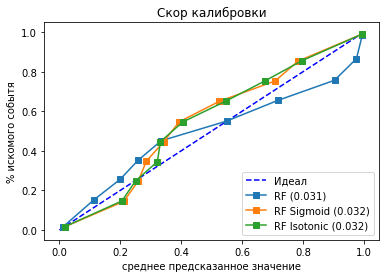

In [62]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Идеал")
ax.set_ylabel("% искомого событя")
ax.set_xlabel("среднее предсказанное значение")
ax.set_title('Скор калибровки')

model_rfc = RandomForestClassifier()
mpv, fp, score = get_calibration_curve_values(model_rfc, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RF', score))

calibrator_sigmoid = CalibratedClassifierCV(RandomForestClassifier(), cv=5, method='sigmoid')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RF Sigmoid', score))

calibrator_isotonic = CalibratedClassifierCV(RandomForestClassifier(), cv=5, method='isotonic')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RF Isotonic', score))

ax.legend(loc="lower right")
plt.show()

#### Для LogReg

F1: 0.91
F1: 0.91
F1: 0.91


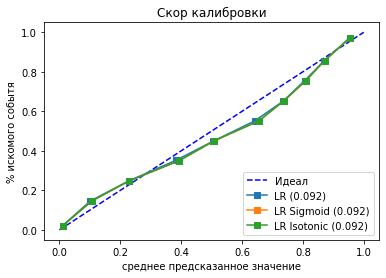

In [63]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Идеал")
ax.set_ylabel("% искомого событя")
ax.set_xlabel("среднее предсказанное значение")
ax.set_title('Скор калибровки')

X_train, X_train2, y_train, y_train2 = train_test_split(X_train, y_train, test_size=0.5)

model_rfc = LogisticRegression()
mpv, fp, score = get_calibration_curve_values(model_rfc, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('LR', score))

calibrator_sigmoid = CalibratedClassifierCV(model_rfc, cv='prefit', method='sigmoid')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train2, y_train2, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('LR Sigmoid', score))

calibrator_isotonic = CalibratedClassifierCV(model_rfc, cv='prefit', method='isotonic')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train2, y_train2, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('LR Isotonic', score))

ax.legend(loc="lower right")
plt.show()

**Важно:**

- после калибровки метрика может быть меньше/больше (чаще всего в меньшую), это нормально.